In [9]:
import cv2
import numpy as np
import math
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
GREEN = np.array([64,128,0], dtype = np.uint8)
BLUE = np.array([255,128,32], dtype = np.uint8)
GRAY = np.array([206,186,186], dtype = np.uint8)

In [62]:
img = cv2.imread('mytable3.jpeg')

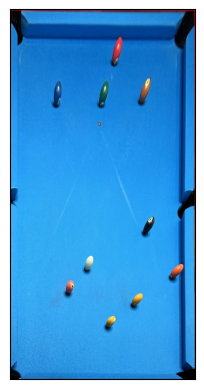

In [63]:
color = BLUE

hsvImage = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
low, high = get_limits(color, error = 20)

if color is GRAY:
    mask = cv2.inRange(img, color-30, color+30)
else:
    mask = cv2.inRange(hsvImage, low, high)

contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
for i in range(len(contours)):
    if cv2.contourArea(contours[i])>max_area:
        max_ind = i
        max_area = cv2.contourArea(contours[i])
        
hull = cv2.convexHull(contours[max_ind])

drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

cv2.drawContours(drawing, [hull], 0, (0,128,0),1)

drawing = cv2.cvtColor(drawing, cv2.COLOR_BGR2GRAY)

lines = cv2.HoughLines(drawing, 1, np.pi / 180, 120, None, 0, 0)

drawing2 = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

linesavg = []

for line in lines:
    temp = True
    for lineavg in linesavg:
        if abs((line[0][0]-lineavg[0][0])/img.shape[1])<0.1 and abs(line[0][1]-lineavg[0][1])<0.2:
            lineavg[0]=(line[0]+lineavg[0])/2
            temp = False
            break
    if temp:
        linesavg.append(line)
        
lines = []

if lines is not None:
    for i in range(len(linesavg)):
        rho = linesavg[i][0][0]
        theta = linesavg[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        if abs(a)<abs(b):
            d = max(abs((x0-img.shape[1])/b), abs(x0/b))
        else:
            d = max(abs((y0-img.shape[0])/a), abs(y0/a))
        pt1 = (int(x0 + d*(-b)), int(y0 + d*(a)))
        pt2 = (int(x0 - d*(-b)), int(y0 - d*(a)))
        lines.append((pt1, pt2))
        cv2.line(img, pt1, pt2, (0,0,255), 1, cv2.LINE_AA)

tc = []
    
for j in range(1, 4):
    x1, y1 = lines[0][0]
    x2, y2 = lines[0][1]
    w1, z1 = lines[j][0]
    w2, z2 = lines[j][1]
    N = (z1-y1)*(x2-x1)-(w1-x1)*(y2-y1)
    D = (w2-w1)*(y2-y1)-(z2-z1)*(x2-x1)
    if abs(N) < abs(D) and N*D > 0:
        s = N/D
        pt = np.array([int(w1+s*(w2-w1)), int(z1+s*(z2-z1))])
        if pt[0]>0 and pt[0]<img.shape[1] and pt[1]>0 and pt[1]<img.shape[0]:
            tc.append(pt)
    else:
        i = j
        
for j in range(1, 4):
    if i != 4-j:
        x1, y1 = lines[i][0]
        x2, y2 = lines[i][1]
        w1, z1 = lines[4-j][0]
        w2, z2 = lines[4-j][1]
        N = (z1-y1)*(x2-x1)-(w1-x1)*(y2-y1)
        D = (w2-w1)*(y2-y1)-(z2-z1)*(x2-x1)
        if abs(N) < abs(D) and N*D > 0:
            s = N/D
            pt = np.array([int(w1+s*(w2-w1)), int(z1+s*(z2-z1))])
            if pt[0]>0 and pt[0]<img.shape[1] and pt[1]>0 and pt[1]<img.shape[0]:
                tc.append(pt)

tc = order_corners(tc)
tc = np.array(tc)
                
table = np.zeros((320, 640, 3), dtype=np.uint8)
pockets = np.array([[0,0], [0,640], [320,640], [320,0]])

h, status = cv2.findHomography(tc, pockets)
table_img = cv2.warpPerspective(img, h, (table.shape[0],table.shape[1]))
                
plt.imshow(cv2.cvtColor(table_img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [52]:
def get_limits(color, error = 10):
    hsv_c = cv2.cvtColor(np.array([[color]]), cv2.COLOR_BGR2HSV)
    low = [hsv_c[0][0][0] - error, 80, 80]
    high = [hsv_c[0][0][0] + error, 255, 255]
    
    low[0] = max(low[0], 0)
    high[0] = min(high[0], 255)
    
    low = np.array(low, dtype = np.uint8)
    high = np.array(high, dtype = np.uint8)
     
    return low, high

def order_corners(corners):
    shortest_dist = np.linalg.norm(corners[0]-corners[1])
    point = 0
    
    for i in range(1,4):
        if np.linalg.norm(corners[i]-corners[(i+1)%4]) < shortest_dist:
            shortest_dist=np.linalg.norm(corners[i]-corners[(i+1)%4])
            point = i
    
    if corners[point][1] < corners[(point+1)%4][1]:
        for i in range(4):
            corners[i] = corners[(point+1+i)%4]
    else:
        for i in range(4):
            corners[i] = corners[(point-i)%4]
    return corners
        

def export_yolo_data(
    samples,
    export_dir,
    classes,
    label_field = "ground_truth",
    split = None
    ):

    if type(split) == list:
        splits = split
        for split in splits:
            export_yolo_data(
                samples,
                export_dir,
                classes,
                label_field,
                split
            )
    else:
        if split is None:
            split_view = samples
            split = "val"
        else:
            split_view = samples.match_tags(split)

        split_view.export(
            export_dir=export_dir,
            dataset_type=fo.types.YOLOv5Dataset,
            label_field=label_field,
            classes=classes,
            split=split
        )

In [36]:
cap = cv2.VideoCapture('./pool.mp4')

while True:
    ret, frame = cap.read()
    cap.set(cv2.CAP_PROP_POS_FRAMES,1000)
        
    hsvImage = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(hsvImage, low, high)
    
    mask_ = Image.fromarray(mask)
    
    bbox = mask_.getbbox()
    
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        frame = cv2.rectangle(frame, [x1, y1], [x2, y2], (0, 255, 0), 5)
        
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

In [22]:
cv2.destroyAllWindows()

In [20]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

In [21]:
dataset = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              label_types=["detections"],
              classes=["Ball"]
          )



Necessary images already downloaded
Existing download of split 'train' is sufficient
Necessary images already downloaded
Existing download of split 'test' is sufficient
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'open-images-v7'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [22]:
dataset_pool = dataset.match(
    F("ground_truth.detections.label").contains("Billiard table")
)

ball_dataset = dataset_pool.filter_labels(
    "ground_truth",
    F("label") == "Ball"
)

train_dataset = ball_dataset.map_labels(
    "ground_truth",
    {"Ball":"sports ball"}
)


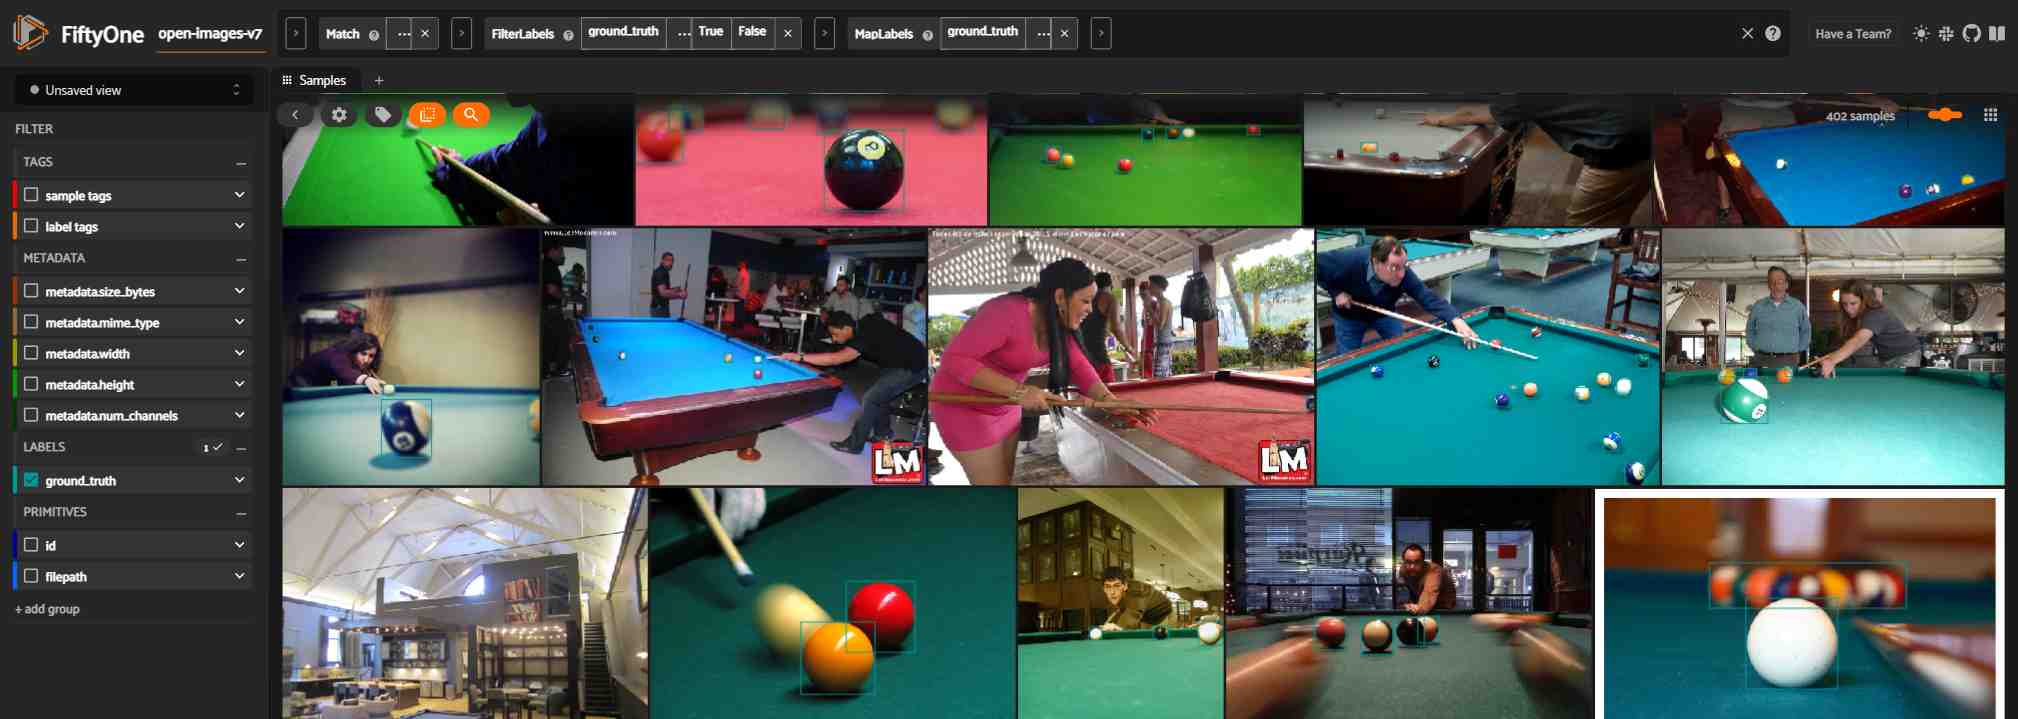

In [19]:
session = fo.launch_app(train_dataset)

In [23]:
import fiftyone.utils.random as four

## delete existing tags to start fresh
train_dataset.untag_samples(train_dataset.distinct("tags"))

## split into train and val
four.random_split(
    train_dataset,
    {"train": 0.9, "val": 0.1}
)

## export in YOLO format
export_yolo_data(
    train_dataset,
    "pool_train",
    ['sports ball'],
    split = ["train", "val"]
)

Directory 'pool_train' already exists; export will be merged with existing files
 100% |█████████████████| 362/362 [1.9s elapsed, 0s remaining, 200.7 samples/s]      
Directory 'pool_train' already exists; export will be merged with existing files
 100% |███████████████████| 40/40 [250.9ms elapsed, 0s remaining, 159.5 samples/s]      


In [24]:
model = YOLO('yolov8m.pt')

In [25]:
model.train(data='pool_train/dataset.yaml', epochs=5, imgsz=640, batch=16)

New https://pypi.org/project/ultralytics/8.0.84 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.78  Python-3.10.10 torch-2.0.0+cpu CPU
yolo\engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=pool_train/dataset.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=

In [36]:
results = model.predict(source=img, save=True, save_txt=True)


0: 480x640 11 sports balls, 360.1ms
Speed: 0.0ms preprocess, 360.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels


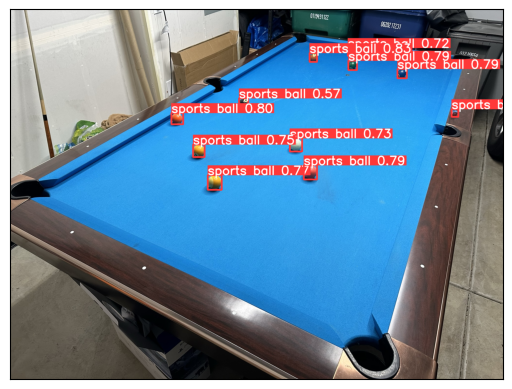

In [37]:
res_plotted = results[0].plot()

plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()